<a href="https://colab.research.google.com/github/dksifoua/Neural-Machine-Translation/blob/master/4%20-%20SeqToSeq%20Model%20with%20Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Oct  3 04:29:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dependencies

In [2]:
!pip install tqdm --upgrade >> /dev/null 2>&1
!pip install torchtext --upgrade >> /dev/null 2>&1
!pip install spacy --upgrade >> /dev/null 2>&1
!python -m spacy download de >> /dev/null 2>&1
!python -m spacy download en >> /dev/null 2>&1

In [4]:
import tqdm
import spacy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Dataset, Example, Field
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score
from torchtext.datasets import Multi30k

In [5]:
!mkdir -p ./checkpoints

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 546
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


## Load data

In [6]:
%%time
DE = Field(init_token='<sos>', eos_token='<eos>', lower=True, tokenize='spacy', tokenizer_language='de', batch_first=True)
EN = Field(init_token='<sos>', eos_token='<eos>', lower=True, tokenize='spacy', tokenizer_language='en', batch_first=True)
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'),  fields=(DE, EN))
print(f'train set size: {len(train_data.examples):,}')
print(f'valid set size: {len(valid_data.examples):,}')
print(f'test set size: {len(test_data.examples):,}')
print(vars(train_data.examples[0]))

training.tar.gz:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 4.90MB/s]
validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.51MB/s]

downloading validation.tar.gz
downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.31MB/s]


train set size: 29,000
valid set size: 1,014
test set size: 1,000
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
CPU times: user 6.11 s, sys: 208 ms, total: 6.31 s
Wall time: 7.01 s


## Build vocabularies

In [7]:
%%time
MIN_COUNT = 2
DE.build_vocab(train_data, min_freq=MIN_COUNT)
EN.build_vocab(train_data, min_freq=MIN_COUNT)
print(f'Length of DE vocabulary: {len(DE.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of DE vocabulary: 7,854
Length of EN vocabulary: 5,893
CPU times: user 291 ms, sys: 2.93 ms, total: 294 ms
Wall time: 295 ms


## Modeling

***Encoder Layer***

In [8]:
class EncoderLayer(nn.Module):

    def __init__(self, vocab_size, max_length, embedding_size, hidden_size, kernel_size, n_layers, scale, dropout):
        super(EncoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.n_layers = n_layers
        self.scale = scale
        self.dropout = nn.Dropout(dropout)
        self.token_embedding = nn.Embedding(vocab_size, embedding_size)
        self.position_embedding = nn.Embedding(max_length, embedding_size)
        self.fc_embedding_hidden = nn.Linear(embedding_size, hidden_size)
        self.fc_hidden_embedding = nn.Linear(hidden_size, embedding_size)
        self.conv1ds = nn.ModuleList([nn.Conv1d(hidden_size, hidden_size * 2, kernel_size=kernel_size,
                                                padding=(kernel_size - 1) // 2) for _ in range(n_layers)])

    def forward(self, input_sequences):
        """
        :param Tensor[batch_size, src_len] input_sequences
        :return Tensor[batch_size, src_len, embedding_size] embedded
        :return Tensor[batch_size, src_len, embedding_size] conv_output
        """
        positions = torch.arange(0, input_sequences.size(1)).unsqueeze(0).repeat(input_sequences.size(0), 1).to(input_sequences.device)
        position_embedded = self.position_embedding(positions) # [batch_size, src_len, embedding_size]
        token_embedded = self.token_embedding(input_sequences) # [batch_size, src_len, embedding_size]
        embedded = self.dropout(position_embedded + token_embedded) # [batch_size, src_len, embedding_size]
        conv_output = self.fc_embedding_hidden(embedded) # [batch_size, src_len, hidden_size]
        conv_output = conv_output.permute(0, 2, 1) # [batch_size, hidden_size, src_len]
        for conv1d in self.conv1ds:
            conv_output = self.dropout(conv_output)
            conved = conv1d(conv_output) # [batch_size, hidden_size * 2, src_len]
            conved = F.glu(conved, dim=1) # [batch_size, hidden_size, src_len]
            conv_output = (conved + conv_output) * self.scale # [batch_size, hidden_size, src_len] Residual connection
        conv_output = conv_output.permute(0, 2, 1) # [batch_size, src_len, hidden_size]
        conv_output = self.fc_hidden_embedding(conv_output) # [batch_size, src_len, embedding_size]
        return embedded, conv_output

***Decoder Layer***

In [9]:
class DecoderLayer(nn.Module):

    def __init__(self, vocab_size, max_length, embedding_size, hidden_size, kernel_size, n_layers, scale, dropout):
        super(DecoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.n_layers = n_layers
        self.scale = scale
        self.dropout = nn.Dropout(dropout)
        self.token_embedding = nn.Embedding(vocab_size, embedding_size)
        self.position_embedding = nn.Embedding(max_length, embedding_size)
        self.fc_embedding_hidden = nn.Linear(embedding_size, hidden_size)
        self.fc_hidden_embedding = nn.Linear(hidden_size, embedding_size)
        self.fc_embedding_hidden_attn = nn.Linear(embedding_size, hidden_size)
        self.fc_hidden_embedding_attn = nn.Linear(hidden_size, embedding_size)
        self.conv1ds = nn.ModuleList([nn.Conv1d(hidden_size, hidden_size * 2, kernel_size=kernel_size,
                                                padding=(kernel_size - 1)) for _ in range(n_layers)])
        self.fc = nn.Linear(embedding_size, vocab_size)
    
    def calculate_attention(self, hidden_state, embedded, enc_conved):
        """
        :param Tensor[batch_size, hidden_size, dest_len] hidden_state
        :param Tensor[batch_size, dest_len, embedding_size] embedded
        :param Tensor[batch_size, src_len, embedding_size] enc_conved
        :return Tensor[batch_size, dest_len, src_len] attn_weights
        """
        hidden_state = self.fc_hidden_embedding_attn(hidden_state.permute(0, 2, 1)) # [batch_size, dest_len, embedding_size]
        combined = hidden_state + embedded # [batch_size, dest_len, embedding_size]
        scores = torch.matmul(combined, enc_conved.permute(0, 2, 1)) # [batch_size, dest_len, src_len]
        attn_weights = F.softmax(scores, dim=2) # [batch_size, dest_len, src_len]
        return attn_weights
        
    def forward(self, input_sequences, encoder_conved, encoder_embedded):
        """
        :param Tensor[batch_size, dest_len] input_sequences
        :param Tensor[batch_size, src_len, embedding_size] encoder_conved
        :param Tensor[batch_size, src_len, embedding_size] encoder_embedded
        :return Tensor[batch_size, dest_seq_len, vocab_size] logits
        :return Tensor[batch_size, dest_len, src_len] attn_weights
        """
        positions = torch.arange(0, input_sequences.size(1)).unsqueeze(0).repeat(input_sequences.size(0), 1).to(input_sequences.device)
        position_embedded = self.position_embedding(positions) # [batch_size, dest_len, embedding_size]
        token_embedded = self.token_embedding(input_sequences) # [batch_size, dest_len, embedding_size]
        embedded = self.dropout(position_embedded + token_embedded) # [batch_size, dest_len, embedding_size]
        conv_output = self.fc_embedding_hidden(embedded) # [batch_size, dest_len, hidden_size]
        conv_output = conv_output.permute(0, 2, 1) # [batch_size, hidden_size, dest_len]
        for conv1d in self.conv1ds:
            conv_output = self.dropout(conv_output)
            conved = conv1d(conv_output) # [batch_size, hidden_size * 2, dest_len + kernel_size - 1]
            conved = F.glu(conved[:, :, :-(self.kernel_size - 1)], dim=1) # [batch_size, hidden_size, dest_len]
            conv_output = (conved + conv_output) * self.scale # [batch_size, hidden_size, dest_len] Residual connection
            attn_weights = self.calculate_attention(hidden_state=conv_output, embedded=embedded, enc_conved=encoder_conved) # [batch_size, dest_len, src_len]
            m = encoder_conved.size(1)
            conditional_input = torch.matmul(attn_weights, (encoder_conved + encoder_embedded)) * m * np.sqrt(1 / m)
            # conditional_input [batch_size, dest_len, embedding_size]
            conditional_input = self.fc_embedding_hidden_attn(conditional_input) # [batch_size, dest_len, hidden_size]
            conv_output = (conv_output + conditional_input.permute(0, 2, 1)) * self.scale # [batch_size, hidden_size, dest_len]
        conved = self.fc_hidden_embedding(conv_output.permute(0, 2, 1)) # [batch_size, dest_len, embedding_size]
        logits = self.fc(self.dropout(conved)) # [batch_size, dest_seq_len, vocab_size]
        return logits, attn_weights

***Sequence-to-sequence model***

In [10]:
class SeqToSeqNet(nn.Module):

    def __init__(self, encoder, decoder):
        assert encoder.n_layers == decoder.n_layers, 'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, 'Encoder and Decoder must have the same number of reccurrent hidden units'
        super(SeqToSeqNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src_sequences, dest_sequences):
        """
        :param Tensor[batch_size, src_seq_len] src_sequences
        :param Tensor[batch_size, dest_seq_len] dest_sequences
        :return Tensor[batch_size, dest_seq_len, vocab_size] logits
        :return [batch_size, dest_seq_len, src_seq_len] attn_weights
        """
        encoder_embedded, encoder_conved = self.encoder(src_sequences) # Encoding
        logits, attn_weights = self.decoder(dest_sequences, encoder_conved, encoder_embedded) # Decoding
        return logits, attn_weights

***Training routines***

In [11]:
class AverageMeter:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [12]:
def accuracy(outputs, target_sequences, k=5):
    """
    :param Tensor[batch_size, dest_seq_len, vocab_size] outputs
    :param Tensor[batch_size, dest_seq_len] target_sequences
    :return float Top-k accuracy
    """
    # print([*map(lambda token: EN.vocab.itos[token], outputs.argmax(dim=-1)[0].tolist())])
    # print([*map(lambda token: EN.vocab.itos[token], target_sequences[0].tolist())])
    # print("="*100)
    batch_size = target_sequences.size(0)
    _, indices = outputs.topk(k, dim=2, largest=True, sorted=True) # [batch_size, dest_seq_len, 5]
    correct = indices.eq(target_sequences.unsqueeze(-1).expand_as(indices))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / indices.numel())

In [14]:
class Trainer:

    def __init__(self, model, optimizer, criterion, train_iterator, valid_iterator):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_iterator = train_iterator
        self.valid_iterator = valid_iterator

    def clip_gradients(self, grad_clip):
        if grad_clip is not None:
            for group in self.optimizer.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        param.grad.data.clamp_(-grad_clip, grad_clip)

    def adjust_lr(self, shrink_factor=0.9, verbose=True):
        if verbose:
            print("\nDecaying learning rate.")
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * shrink_factor
        if verbose:
            print("The new learning rate is %f\n" % (self.optimizer.param_groups[0]['lr'],))
    
    def train_step(self, epoch, grad_clip):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(self.train_iterator), total=len(self.train_iterator))
        for i, batch in progress_bar:
            src, trg = batch.src, batch.trg
            self.optimizer.zero_grad()
            logits, _ = self.model(src, trg[:, :-1]) # [batch_size, dest_len, vocab_size]
            loss = self.criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), trg[:, 1:].contiguous().view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
            self.optimizer.step()
            loss_tracker.update(loss.item())
            acc_tracker.update(accuracy(logits, trg[:, 1:]))
            loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_:.3f} -     ppl: {ppl_:.3f} -     acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def validate(self, epoch):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(self.valid_iterator), total=len(self.valid_iterator))
            for i, batch in progress_bar:
                src, trg = batch.src, batch.trg
                logits, _ = self.model(src, trg[:, :-1]) # [batch_size, dest_len, vocab_size]
                loss = self.criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), trg[:, 1:].contiguous().view(-1))
                loss_tracker.update(loss.item())
                acc_tracker.update(accuracy(logits, trg[:, 1:]))
                loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_:.3f} - val_ppl: {ppl_:.3f} - val_acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def train(self, n_epochs, grad_clip):
        history = {'acc': [], 'loss': [], 'ppl': [], 'val_ppl': [], 'val_acc': [], 'val_loss': []}
        best_loss, last_improv = np.inf, 0
        for epoch in range(n_epochs):
            if last_improv == 4:
                print('Training Finished - The model has stopped improving since last 4 epochs')
                break
            if last_improv > 0:
                self.adjust_lr()
            loss, ppl, acc = self.train_step(epoch, grad_clip)
            val_loss, val_ppl, val_acc = self.validate(epoch)
            
            if best_loss > val_loss:
                best_loss, last_improv = val_loss, 0
                torch.save(self.model.state_dict(), './checkpoints/seq2seq-convolution.pth')
            else:
                last_improv += 1
                print(f'\nLast improvement since epoch {epoch - last_improv + 1}')
            
            history['acc'].append(acc)
            history['ppl'].append(ppl)
            history['loss'].append(loss)
            history['val_acc'].append(val_acc)
            history['val_ppl'].append(val_ppl)
            history['val_loss'].append(val_loss)
        return history

***Train the model***

In [15]:
def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=np.sqrt(1 / m.in_features))
        if m.bias is not None: 
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.Conv1d):
        nn.init.normal_(m.weight, mean=0.0, std=np.sqrt(4 / m.in_channels))
        if m.bias is not None: 
            nn.init.zeros_(m.bias)

In [16]:
N_LAYERS = 2
HIDDEN_SIZE = 256
EMBED_SIZE = 300
KERNEL_SIZE = 3
DROPOUT = 0.25
SCALE = np.sqrt(0.5)
MAX_LEN = 50
N_EPOCHS = 10
BATCH_SIZE = 64
LR = 1e-3
GRAD_CLIP = 0.1

In [20]:
encoder_layer = EncoderLayer(vocab_size=len(DE.vocab), max_length=MAX_LEN, embedding_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE,
                             kernel_size=KERNEL_SIZE, scale=SCALE, n_layers=N_LAYERS, dropout=DROPOUT)
decoder_layer = DecoderLayer(vocab_size=len(EN.vocab), max_length=MAX_LEN, embedding_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, 
                             kernel_size=KERNEL_SIZE, scale=SCALE, n_layers=N_LAYERS, dropout=DROPOUT)
seq2seq = SeqToSeqNet(encoder=encoder_layer, decoder=decoder_layer).to(DEVICE)
seq2seq.apply(init_weights)
optimizer = optim.RMSprop(params=seq2seq.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=EN.vocab.stoi[EN.pad_token])
print(f'Number of parameters of the model: {sum(p.numel() for p in seq2seq.parameters() if p.requires_grad):,}')
print(seq2seq)
train_iterator, valid_iterator, test_iterator =  BucketIterator.splits((train_data, valid_data, test_data), batch_size=BATCH_SIZE, device=DEVICE)
trainer = Trainer(model=seq2seq, optimizer=optimizer, criterion=criterion, train_iterator=train_iterator, valid_iterator=valid_iterator)

Number of parameters of the model: 7,965,273
SeqToSeqNet(
  (encoder): EncoderLayer(
    (dropout): Dropout(p=0.25, inplace=False)
    (token_embedding): Embedding(7854, 300)
    (position_embedding): Embedding(50, 300)
    (fc_embedding_hidden): Linear(in_features=300, out_features=256, bias=True)
    (fc_hidden_embedding): Linear(in_features=256, out_features=300, bias=True)
    (conv1ds): ModuleList(
      (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
  (decoder): DecoderLayer(
    (dropout): Dropout(p=0.25, inplace=False)
    (token_embedding): Embedding(5893, 300)
    (position_embedding): Embedding(50, 300)
    (fc_embedding_hidden): Linear(in_features=300, out_features=256, bias=True)
    (fc_hidden_embedding): Linear(in_features=256, out_features=300, bias=True)
    (fc_embedding_hidden_attn): Linear(in_features=300, out_features=256, bias=True)
    (fc_hidden_embedding_attn)

In [21]:
history = trainer.train(n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

Epoch: 01 -     loss: 4.701 -     ppl: 110.057 -     acc: 5.286%: 100%|██████████| 454/454 [00:11<00:00, 39.42it/s]
Epoch: 01 - val_loss: 2.837 - val_ppl: 17.071 - val_acc: 12.207%: 100%|██████████| 16/16 [00:00<00:00, 57.88it/s]
Epoch: 02 -     loss: 2.815 -     ppl: 16.700 -     acc: 7.460%: 100%|██████████| 454/454 [00:11<00:00, 39.05it/s]
Epoch: 02 - val_loss: 2.234 - val_ppl: 9.337 - val_acc: 13.525%: 100%|██████████| 16/16 [00:00<00:00, 115.57it/s]
Epoch: 03 -     loss: 2.361 -     ppl: 10.600 -     acc: 8.085%: 100%|██████████| 454/454 [00:11<00:00, 39.38it/s]
Epoch: 03 - val_loss: 2.000 - val_ppl: 7.389 - val_acc: 13.963%: 100%|██████████| 16/16 [00:00<00:00, 114.51it/s]
Epoch: 04 -     loss: 2.098 -     ppl: 8.148 -     acc: 8.416%: 100%|██████████| 454/454 [00:11<00:00, 39.05it/s]
Epoch: 04 - val_loss: 1.832 - val_ppl: 6.244 - val_acc: 14.352%: 100%|██████████| 16/16 [00:00<00:00, 117.26it/s]
Epoch: 05 -     loss: 1.914 -     ppl: 6.782 -     acc: 8.667%: 100%|██████████| 454


Last improvement since epoch 9


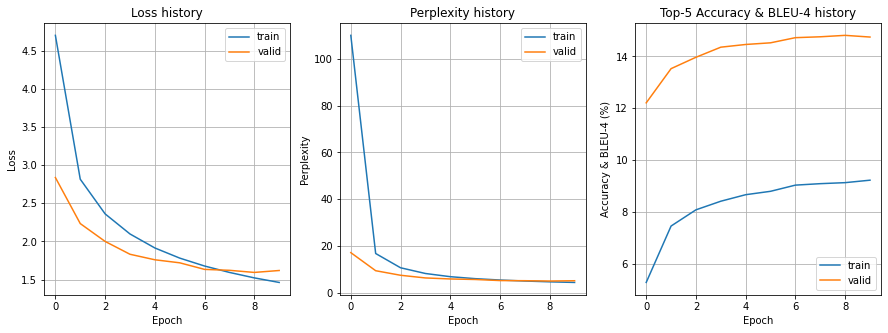

In [22]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['acc'], label='train')
axes[2].plot(history['val_acc'], label='valid')
axes[2].set_title('Top-5 Accuracy & BLEU-4 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy & BLEU-4 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

## Evaluation - Beam search & BLEU score

In [23]:
seq2seq.load_state_dict(torch.load('./checkpoints/seq2seq-convolution.pth'))
seq2seq.to(DEVICE)

SeqToSeqNet(
  (encoder): EncoderLayer(
    (dropout): Dropout(p=0.25, inplace=False)
    (token_embedding): Embedding(7854, 300)
    (position_embedding): Embedding(50, 300)
    (fc_embedding_hidden): Linear(in_features=300, out_features=256, bias=True)
    (fc_hidden_embedding): Linear(in_features=256, out_features=300, bias=True)
    (conv1ds): ModuleList(
      (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
  (decoder): DecoderLayer(
    (dropout): Dropout(p=0.25, inplace=False)
    (token_embedding): Embedding(5893, 300)
    (position_embedding): Embedding(50, 300)
    (fc_embedding_hidden): Linear(in_features=300, out_features=256, bias=True)
    (fc_hidden_embedding): Linear(in_features=256, out_features=300, bias=True)
    (fc_embedding_hidden_attn): Linear(in_features=300, out_features=256, bias=True)
    (fc_hidden_embedding_attn): Linear(in_features=256, out_features=300, b

In [25]:
from beam_utils import Node, find_best_path, find_path

def evaluate(model, data, beam_size, src_field, dest_field, max_len, device):
    src_sentences = [*map(lambda example: example.src, data.examples)]
    dest_sentences = [*map(lambda example: example.trg, data.examples)]
    data = [*zip([*map(lambda word_list: src_field.process([word_list]), src_sentences)],
                 [*map(lambda word_list: dest_field.process([word_list]), dest_sentences)])]
    references, hypotheses, sources = [], [], []
    model.eval()
    with torch.no_grad():
        for i, (src_sequence, dest_sequence) in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence, dest_sequence = src_sequence.to(device), dest_sequence.to(device)
            encoder_embedded, encoder_conved = model.encoder(src_sequence) # Encoding            
            # Decoding
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=None)]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    # Get tokens that're already translated
                    already_translated = torch.LongTensor([*map(lambda node: node.token, find_path(tree))][::-1]).unsqueeze(0).to(device)
                    logit, _ = model.decoder(already_translated, encoder_conved, encoder_embedded) # [1, dest_seq_len, vocab_size]                    
                    logp = F.log_softmax(logit[:, -1, :], dim=1).squeeze(dim=0) # [vocab_size] Get scores                    
                    topk_logps, topk_tokens = torch.topk(logp, beam_size) # Get top k tokens & logps                    
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=None,
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True) # Sort next_nodes to get the best
                tree.append(next_nodes[:beam_size]) # Update the tree
            best_path = find_best_path(tree) # Find the best path of the tree

            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [dest_field.init_token, dest_field.eos_token], pred_translated[::-1])]

            hypotheses.append(pred_translated) # Update hypotheses

            # Update references
            references.append([[dest_field.vocab.itos[indice] for indice in dest_sequence[0] if indice not in (
                dest_field.vocab.stoi[dest_field.init_token],
                dest_field.vocab.stoi[dest_field.eos_token],
                dest_field.vocab.stoi[dest_field.pad_token]
            )]])

            # Update sources
            sources.append([src_field.vocab.itos[indice]  for indice in src_sequence[0] if indice not in (
                src_field.vocab.stoi[src_field.init_token],
                src_field.vocab.stoi[src_field.eos_token],
                src_field.vocab.stoi[src_field.pad_token]
            )])
    
        assert len(hypotheses) == len(references) == len(sources)
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25]) # Calculate BLEU-4 score
    return hypotheses, references, sources, bleu4

In [26]:
bleu_scores = []
for beam_size in [1, 3, 5]:
    for name, data in [('validation', valid_data), ('test', test_data)]:
        _, _, _, bleu4 = evaluate(model=seq2seq, data=data, beam_size=beam_size, src_field=DE, dest_field=EN, max_len=MAX_LEN, device=DEVICE)
        bleu_scores.append((beam_size, name, bleu4))
        
for score in bleu_scores:
    print(f'BLEU-4: {score[2]*100:.3f}% with beam_size={score[0]} on {score[1]} data')

100%|██████████| 1000/1000 [02:31<00:00,  6.58it/s]


BLEU-4: 37.321% with beam_size=1 on validation data
BLEU-4: 37.428% with beam_size=1 on test data
BLEU-4: 37.321% with beam_size=3 on validation data
BLEU-4: 37.428% with beam_size=3 on test data
BLEU-4: 37.321% with beam_size=5 on validation data
BLEU-4: 37.428% with beam_size=5 on test data


## Inference

In [43]:
def translate(sentences, model, beam_size, src_field, dest_field, max_len, device):
    if isinstance(sentences, list):
        sentences = [*map(src_field.preprocess, sentences)]
        targets = None
    if isinstance(sentences, Dataset):
        targets = [*map(lambda example: ' '.join(example.trg), sentences.examples)]
        sentences = [*map(lambda example: example.src, sentences.examples)]
    data = [*map(lambda word_list: src_field.process([word_list]), sentences)]
    translated_sentences, attention_weights, pred_logps = [], [], []
    model.eval()
    with torch.no_grad():
        for i, src_sequence in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence = src_sequence.to(device)
            encoder_embedded, encoder_conved = model.encoder(src_sequence) # Encoding
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=())]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    # Get tokens that're already translated
                    already_translated = torch.LongTensor([*map(lambda node: node.token, find_path(tree))][::-1]).unsqueeze(0).to(device)
                    logit, attn_weights = model.decoder(already_translated, encoder_conved, encoder_embedded)                   
                    logp = F.log_softmax(logit[:, -1, :], dim=1).squeeze(dim=0) # [vocab_size] Get scores                    
                    topk_logps, topk_tokens = torch.topk(logp, beam_size) # Get top k tokens & logps                    
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=(attn_weights,),
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True)
                tree.append(next_nodes[:beam_size])
            best_path = find_best_path(tree)[::-1]
            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [
                dest_field.init_token, dest_field.eos_token
            ], pred_translated)]
            translated_sentences.append(' '.join(pred_translated))
            # Get probabilities
            pred_logps.append(sum([*map(lambda node: node.logps, best_path)]))
            # Get attention weights
            attention_weights.append(best_path[-1].states[0].cpu().numpy())
        sentences = [*map(lambda sentence: ' '.join(sentence), sentences)]
    return sentences, translated_sentences, targets, attention_weights, pred_logps

In [74]:
def plot_attention(src, trg, scores):
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='bone')

    ax.set_xticklabels(trg.split(), minor=False, rotation='vertical')
    ax.set_yticklabels(src.split(), minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

100%|██████████| 1000/1000 [02:26<00:00,  6.81it/s]

[ 41 486  21 157 699 989 695 155  87 537]



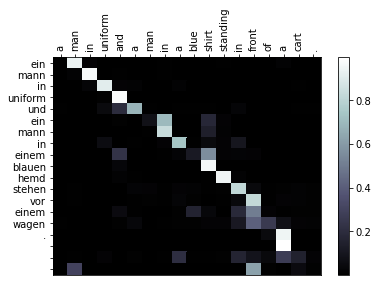

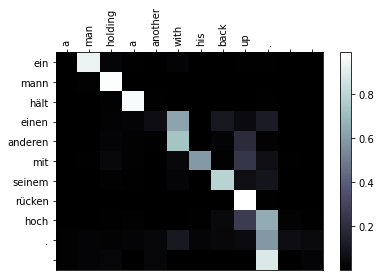

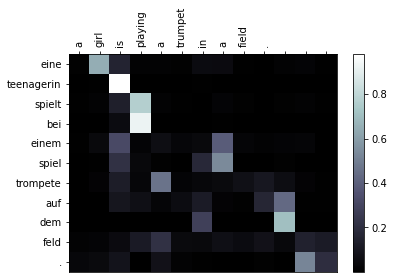

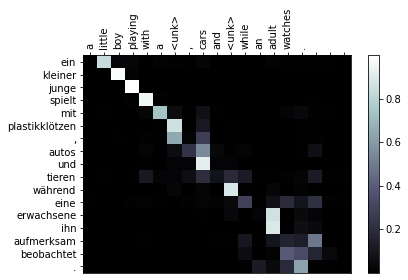

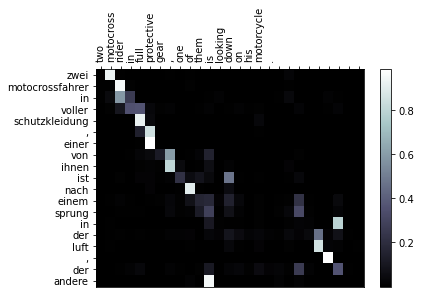

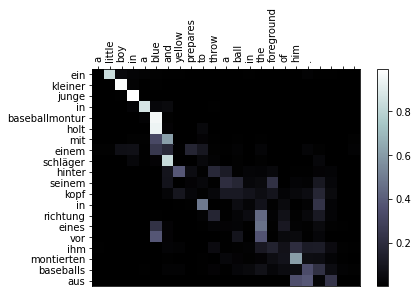

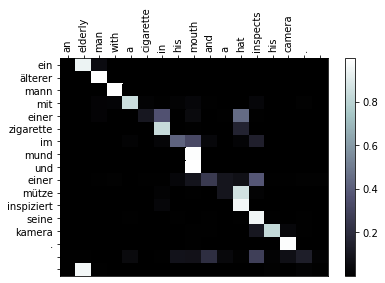

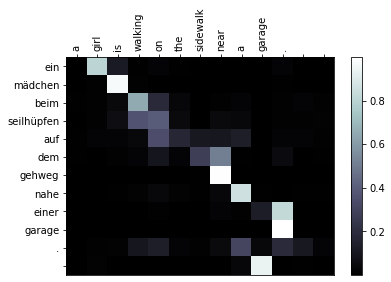

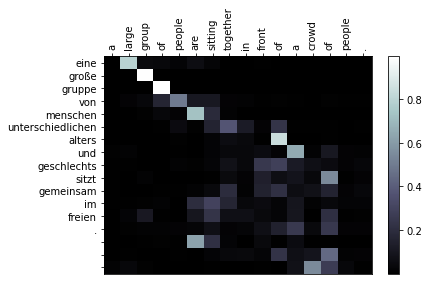

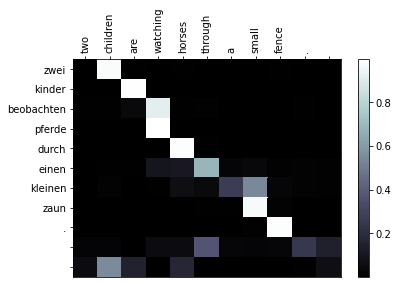

In [76]:
sentences, translated_sentences, dest_sentences, attention_weights, pred_logps = translate(sentences=test_data, model=seq2seq, beam_size=5, src_field=DE,
                                                                                           dest_field=EN, max_len=50, device=DEVICE)
indexes = np.random.choice(len(test_data.examples), size=10, replace=False)
print(indexes)
print()
for i in indexes:
    html = f'<p><span style="color:blue"><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:red"><b>Predicted translation:</b> {translated_sentences[i]}</span></p>'
    display(HTML(html))
    plot_attention(sentences[i], translated_sentences[i], attention_weights[i][0])
    print('='*100)

## Error Analysis

In [77]:
def get_dest_logp(model, data, src_field, dest_field, device):
    dest_logps = []
    model.eval()
    with torch.no_grad():
        for i, data in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence, src_length = src_field.process([data.src])
            dest_sequence, dest_length = dest_field.process([data.trg])
            src_sequence, src_length = src_sequence.to(device), src_length.to(device)
            dest_sequence, dest_length = dest_sequence.to(device), dest_length.to(device)
            enc_outputs, h_state, mask = model.encode(src_sequence, src_length)
            logps = []
            input_word_index = torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device)
            for idx in range(dest_sequence.shape[0]):
                logit, h_state, _ = model.decoder(input_word_index=input_word_index, h_state_prev=h_state.contiguous(), enc_outputs=enc_outputs, mask=mask)
                logp = F.log_softmax(logit, dim=1).squeeze(dim=0)
                input_word_index = dest_sequence[idx]
                logps.append(logp[input_word_index].cpu().item()) # Get logp of ground truth ouput
            dest_logps.append(sum(logps))
    return dest_logps

In [ ]:
dest_logps = get_dest_logp(model=seq2seq, data=test_data, src_field=DE, dest_field=EN, device=DEVICE)
assert len(pred_logps) == len(dest_logps) == len(test_data), f'{len(pred_logps)}, {len(dest_logps)}, {len(test_data)}'

In [ ]:
beam_search_faults = np.array(dest_logps) > np.array(pred_logps)

beam_search_fault_rate = beam_search_faults.sum() / beam_search_faults.size
print(f'Beam search fault rate: {beam_search_fault_rate * 100:.3f}%')
print(f'Model fault rate: {(1 - beam_search_fault_rate) * 100:.3f}%')

In [ ]:
beam_search_fault_indexes = np.where(beam_search_faults == True)[0]
model_fault_indexes = np.where(beam_search_faults == False)[0]

In [ ]:
for i in np.random.choice(beam_search_fault_indexes, size=5, replace=False):
    html = f'<p><span><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:red"><b>Predicted translation (Beam search fault):</b> {translated_sentences[i]}</span><br />'
    display(HTML(html))
    print('='*100)

In [ ]:
for i in np.random.choice(model_fault_indexes, size=5, replace=False):
    html = f'<p><span><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:blue"><b>Predicted translation (Model fault):</b> {translated_sentences[i]}</span><br />'
    display(HTML(html))
    print('='*100)

In [ ]:
lengths = np.array([*map(len, dest_sentences)])

_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(lengths[beam_search_fault_indexes])
axes[0].set_title('Lengths of beam search faults')
axes[0].grid(True)
axes[1].hist(lengths[model_fault_indexes])
axes[1].set_title('Lengths of model faults')
axes[1].grid(True)
plt.show()